<a href="https://colab.research.google.com/github/ykim879/whats.todays.trend/blob/master/revised_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import queue
import threading
def eachNewsHeadlines(ID, q):
	response = requests.get('https://newsapi.org/v2/top-headlines?sources=' + ID + '&apiKey=' + key)
	json = response.json()
	if json['status'] != 'ok':
		raise IOError('API key is probably overused :(')
	topNews = []
	topNews.append(ID)
	for elem in json['articles']:
		topNews.append(elem['title'])
	q.put(topNews)

In [2]:
import requests
import pandas as pd
key = '5e74c7cf9e344e3e8c04210f9b75125b'
response = requests.get('https://newsapi.org/v2/sources?'
			   'language=en&country=us&'
			   'apiKey=' + key)
sources = response.json()['sources']
df = pd.DataFrame();
pd.set_option('display.max_columns', 7)
for source in sources:
  row = pd.Series(source)
  df = df.append(row, ignore_index = True)
df.set_index("name", inplace = True)
#collects headline
threads = []
q = queue.Queue()
for id in df['id']:
  t = threading.Thread(target = eachNewsHeadlines, args = (id, q))
  threads.append(t)
  t.start()
for t in threads:
  t.join()
headlines = []
while not q.empty():
  headlines.extend(q.get())

   keywords  counts
0     world      23
1     watch      22
2     trump      21
3      time      20
4   thehill      19
5    police      18
6    people      17
7  pandemic      16
8       joe      15
9   insider      14


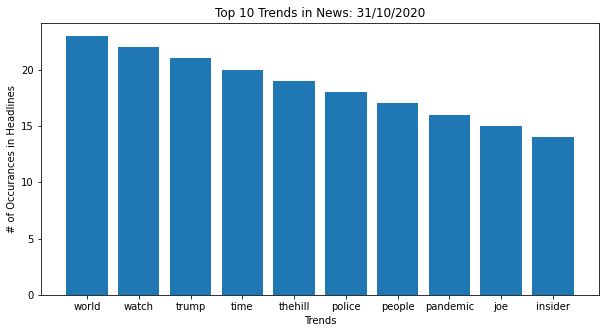

In [7]:
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
from datetime import date

today = date.today()
d1 = today.strftime("%d/%m/%Y")
stop_words = text.ENGLISH_STOP_WORDS.union({'says','news','new'})
vectorizer = text.CountVectorizer(stop_words=stop_words, min_df=10)
X = vectorizer.fit_transform(headlines)
keywordDCT = sorted(vectorizer.vocabulary_.items(), key = lambda x:x[1], reverse = True)
keywordDF = pd.DataFrame(keywordDCT, columns = ['keywords', 'counts'])
print(keywordDF[:10])
plt.figure(figsize=(10,5))
plt.bar(keywordDF['keywords'][:10], keywordDF['counts'][:10])
plt.title('Top 10 Trends in News: ' + d1)
plt.ylabel('# of Occurances in Headlines')
plt.xlabel('Trends')
plt.show()

In [17]:
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction import text
import matplotlib.pyplot as plt
stop_words = text.ENGLISH_STOP_WORDS
data = pd.read_csv('BBC News Train.csv')
print("The original files: Total: 1489 documents with 5 categories")
print(data)

The original files: Total: 1489 documents with 5 categories
      ArticleId                                               Text  \
0          1833  worldcom ex-boss launches defence lawyers defe...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll indicates economic gloom citizens in ...   
3          1976  lifestyle  governs mobile choice  faster  bett...   
4           917  enron bosses in $168m payout eighteen former e...   
...         ...                                                ...   
1485        857  double eviction from big brother model caprice...   
1486        325  dj double act revamp chart show dj duo jk and ...   
1487       1590  weak dollar hits reuters revenues at media gro...   
1488       1587  apple ipod family expands market apple has exp...   
1489        538  santy worm makes unwelcome visit thousands of ...   

           Category  
0          business  
1          business  
2          business  
3          

In [18]:
data = data.groupby('Category', sort=True)['Text'].apply(' '.join).reset_index()
print("The appended documents depending on the categories")
print(data)

The appended documents depending on the categories
        Category                                               Text
0       business  worldcom ex-boss launches defence lawyers defe...
1  entertainment  french honour for director parker british film...
2       politics  howard  truanted to play snooker  conservative...
3          sport  wales silent on grand slam talk rhys williams ...
4           tech  lifestyle  governs mobile choice  faster  bett...


In [13]:
r,c = data.shape
documents = []
len_documents = []
y_train = []
MAX_DOCUMENTS = 3000
for i in range(r):
    document = str(data.loc[i,'Text'])
    y_train.append(str(data.loc[i,'Category']))
    len_documents.append(len(document))
    documents.extend(document)
documents.extend(keywordDF['keywords'][:10]) #extend keywords
#Form bag of words model using words used at least 10 times
v = text.CountVectorizer(stop_words=stop_words, min_df = 10)
print(documents)
train = vectorizer.fit_transform(documents).toarray()
x_train = []
for i in len(len_documents) - 1:
    x_train.append(train[:len_documents[i], :])#store in train_x
gnb = GaussianNB()
label = gnb.fit(data[x_train, y_train]).predict(train[len_documents[-1]:])
print(label)#X_test: keywords, x_train, y_train: trained data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

# Evaluation
store predicted data and evaluation from user whether the label is valid
Evaluate the True Positive Rate and Fale Positive Rate by ROC curve
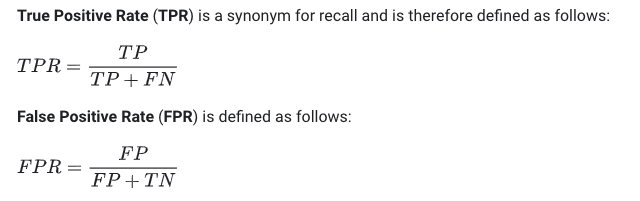

In [ ]:
#get DataFrame from csv
#add current data
#do functions
#store data to csv